In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dimers as dim

In [3]:
import KagomeFunctions as lattice

In [4]:
import itertools

In [5]:
from scipy.special import erfc

In [6]:
from time import time

In [7]:
import DualwormFunctions as dw
import Observables as obs

%load_ext line_profiler
%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw


import matplotlib.pyplot as plt
%matplotlib inline

import yep

In [8]:
nst = 2048;
nsm =32;
nips = 4;
nrps = 4;
nb = 4;
measperiod = 1;
nt = 128
nh = 1
ncores = 4
nmaxiter = 1
L =8
J1 = 1
J2 = 0.1
J3 = 0.2
h = 0
notfullstateupdate = True
stroutput = "LargeJ3_J1{0}J2{1}J3{2}_L{3}_plot2".format(J1,J2,J3,L)

In [9]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = J3,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--testinit', default = True, action = 'store_true',
                        help = '''test some given initialisation''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = '',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--p', type = float, default = 0.0, 
                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')
    parser.add_argument('--ssf', default = True, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = notfullstateupdate, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = False, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.001,60],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = False, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--correlations', default = False, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--all_correlations', default = False, action = 'store_true',
                        help = '''activate if you want to save the correlations for all non-equivalent
                        pairs of sites. Otherwise, will save central correlations.''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose', default = True, action = 'store_true', help = 'verbose')
    args = parser.parse_args()
    return args

In [10]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [11]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
%lprun -f dw.mcs_swaps [meanstat, swapst, swapsh, failedupdatesth, failedupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./LargeJ3_J11J20.1J30.2_L8_plot2_folder/backup.hkl
Lattice side size:  8
J1  1
J2  0.1
J3  0.2
J3st  0.2
Couplings extracted
Hamiltonian expression (without field) computed
single spin flip update
Number of temperatures:  128
Temperatures: [1.00000000e-03 1.09049389e-03 1.18917693e-03 1.29679018e-03
 1.41414178e-03 1.54211297e-03 1.68166478e-03 1.83384518e-03
 1.99979697e-03 2.18076638e-03 2.37811242e-03 2.59331708e-03
 2.82799644e-03 3.08391285e-03 3.36298813e-03 3.66731802e-03
 3.99918791e-03 4.36109000e-03 4.75574202e-03 5.18610763e-03
 5.65541870e-03 6.16719957e-03 6.72529347e-03 7.33389146e-03
 7.99756386e-03 8.72129456e-03 9.51051846e-03 1.03711623e-02
 1.13096892e-02 1.23331470e-02 1.34492215e-02 1.46662939e-02
 1.59935040e-02 1.74408184e-02 1.90191060e-02 2.07402189e-02
 2.26170821e-02 2.46637900e-02 2.68957123e-02 2.93296101e-02
 3.19837607e-02 3.48780958e-02 3.80343505e-02 4.14762270e-02
 4.52295722e-02 4.93225724e-02 5.37

Iteration:  235
   ssf
Iteration:  236
   ssf
Iteration:  237
   ssf
Iteration:  238
   ssf
Iteration:  239
   ssf
Iteration:  240
   ssf
Iteration:  241
   ssf
Iteration:  242
   ssf
Iteration:  243
   ssf
Iteration:  244
   ssf
Iteration:  245
   ssf
Iteration:  246
   ssf
Iteration:  247
   ssf
Iteration:  248
   ssf
Iteration:  249
   ssf
Iteration:  250
   ssf
Iteration:  251
   ssf
Iteration:  252
   ssf
Iteration:  253
   ssf
Iteration:  254
   ssf
Iteration:  255
   ssf
Iteration:  256
   ssf
Iteration:  257
   ssf
Iteration:  258
   ssf
Iteration:  259
   ssf
Iteration:  260
   ssf
Iteration:  261
   ssf
Iteration:  262
   ssf
Iteration:  263
   ssf
Iteration:  264
   ssf
Iteration:  265
   ssf
Iteration:  266
   ssf
Iteration:  267
   ssf
Iteration:  268
   ssf
Iteration:  269
   ssf
Iteration:  270
   ssf
Iteration:  271
   ssf
Iteration:  272
   ssf
Iteration:  273
   ssf
Iteration:  274
   ssf
Iteration:  275
   ssf
Iteration:  276
   ssf
Iteration:  277
   ssf
Iteration: 

Iteration:  593
   ssf
Iteration:  594
   ssf
Iteration:  595
   ssf
Iteration:  596
   ssf
Iteration:  597
   ssf
Iteration:  598
   ssf
Iteration:  599
   ssf
Iteration:  600
   ssf
Iteration:  601
   ssf
Iteration:  602
   ssf
Iteration:  603
   ssf
Iteration:  604
   ssf
Iteration:  605
   ssf
Iteration:  606
   ssf
Iteration:  607
   ssf
Iteration:  608
   ssf
Iteration:  609
   ssf
Iteration:  610
   ssf
Iteration:  611
   ssf
Iteration:  612
   ssf
Iteration:  613
   ssf
Iteration:  614
   ssf
Iteration:  615
   ssf
Iteration:  616
   ssf
Iteration:  617
   ssf
Iteration:  618
   ssf
Iteration:  619
   ssf
Iteration:  620
   ssf
Iteration:  621
   ssf
Iteration:  622
   ssf
Iteration:  623
   ssf
Iteration:  624
   ssf
Iteration:  625
   ssf
Iteration:  626
   ssf
Iteration:  627
   ssf
Iteration:  628
   ssf
Iteration:  629
   ssf
Iteration:  630
   ssf
Iteration:  631
   ssf
Iteration:  632
   ssf
Iteration:  633
   ssf
Iteration:  634
   ssf
Iteration:  635
   ssf
Iteration: 

Iteration:  950
   ssf
Iteration:  951
   ssf
Iteration:  952
   ssf
Iteration:  953
   ssf
Iteration:  954
   ssf
Iteration:  955
   ssf
Iteration:  956
   ssf
Iteration:  957
   ssf
Iteration:  958
   ssf
Iteration:  959
   ssf
Iteration:  960
   ssf
Iteration:  961
   ssf
Iteration:  962
   ssf
Iteration:  963
   ssf
Iteration:  964
   ssf
Iteration:  965
   ssf
Iteration:  966
   ssf
Iteration:  967
   ssf
Iteration:  968
   ssf
Iteration:  969
   ssf
Iteration:  970
   ssf
Iteration:  971
   ssf
Iteration:  972
   ssf
Iteration:  973
   ssf
Iteration:  974
   ssf
Iteration:  975
   ssf
Iteration:  976
   ssf
Iteration:  977
   ssf
Iteration:  978
   ssf
Iteration:  979
   ssf
Iteration:  980
   ssf
Iteration:  981
   ssf
Iteration:  982
   ssf
Iteration:  983
   ssf
Iteration:  984
   ssf
Iteration:  985
   ssf
Iteration:  986
   ssf
Iteration:  987
   ssf
Iteration:  988
   ssf
Iteration:  989
   ssf
Iteration:  990
   ssf
Iteration:  991
   ssf
Iteration:  992
   ssf
Iteration: 

Iteration:  1295
   ssf
Iteration:  1296
   ssf
Iteration:  1297
   ssf
Iteration:  1298
   ssf
Iteration:  1299
   ssf
Iteration:  1300
   ssf
Iteration:  1301
   ssf
Iteration:  1302
   ssf
Iteration:  1303
   ssf
Iteration:  1304
   ssf
Iteration:  1305
   ssf
Iteration:  1306
   ssf
Iteration:  1307
   ssf
Iteration:  1308
   ssf
Iteration:  1309
   ssf
Iteration:  1310
   ssf
Iteration:  1311
   ssf
Iteration:  1312
   ssf
Iteration:  1313
   ssf
Iteration:  1314
   ssf
Iteration:  1315
   ssf
Iteration:  1316
   ssf
Iteration:  1317
   ssf
Iteration:  1318
   ssf
Iteration:  1319
   ssf
Iteration:  1320
   ssf
Iteration:  1321
   ssf
Iteration:  1322
   ssf
Iteration:  1323
   ssf
Iteration:  1324
   ssf
Iteration:  1325
   ssf
Iteration:  1326
   ssf
Iteration:  1327
   ssf
Iteration:  1328
   ssf
Iteration:  1329
   ssf
Iteration:  1330
   ssf
Iteration:  1331
   ssf
Iteration:  1332
   ssf
Iteration:  1333
   ssf
Iteration:  1334
   ssf
Iteration:  1335
   ssf
Iteration:  1336

Iteration:  1638
   ssf
Iteration:  1639
   ssf
Iteration:  1640
   ssf
Iteration:  1641
   ssf
Iteration:  1642
   ssf
Iteration:  1643
   ssf
Iteration:  1644
   ssf
Iteration:  1645
   ssf
Iteration:  1646
   ssf
Iteration:  1647
   ssf
Iteration:  1648
   ssf
Iteration:  1649
   ssf
Iteration:  1650
   ssf
Iteration:  1651
   ssf
Iteration:  1652
   ssf
Iteration:  1653
   ssf
Iteration:  1654
   ssf
Iteration:  1655
   ssf
Iteration:  1656
   ssf
Iteration:  1657
   ssf
Iteration:  1658
   ssf
Iteration:  1659
   ssf
Iteration:  1660
   ssf
Iteration:  1661
   ssf
Iteration:  1662
   ssf
Iteration:  1663
   ssf
Iteration:  1664
   ssf
Iteration:  1665
   ssf
Iteration:  1666
   ssf
Iteration:  1667
   ssf
Iteration:  1668
   ssf
Iteration:  1669
   ssf
Iteration:  1670
   ssf
Iteration:  1671
   ssf
Iteration:  1672
   ssf
Iteration:  1673
   ssf
Iteration:  1674
   ssf
Iteration:  1675
   ssf
Iteration:  1676
   ssf
Iteration:  1677
   ssf
Iteration:  1678
   ssf
Iteration:  1679

Iteration:  1980
   ssf
Iteration:  1981
   ssf
Iteration:  1982
   ssf
Iteration:  1983
   ssf
Iteration:  1984
   ssf
Iteration:  1985
   ssf
Iteration:  1986
   ssf
Iteration:  1987
   ssf
Iteration:  1988
   ssf
Iteration:  1989
   ssf
Iteration:  1990
   ssf
Iteration:  1991
   ssf
Iteration:  1992
   ssf
Iteration:  1993
   ssf
Iteration:  1994
   ssf
Iteration:  1995
   ssf
Iteration:  1996
   ssf
Iteration:  1997
   ssf
Iteration:  1998
   ssf
Iteration:  1999
   ssf
Iteration:  2000
   ssf
Iteration:  2001
   ssf
Iteration:  2002
   ssf
Iteration:  2003
   ssf
Iteration:  2004
   ssf
Iteration:  2005
   ssf
Iteration:  2006
   ssf
Iteration:  2007
   ssf
Iteration:  2008
   ssf
Iteration:  2009
   ssf
Iteration:  2010
   ssf
Iteration:  2011
   ssf
Iteration:  2012
   ssf
Iteration:  2013
   ssf
Iteration:  2014
   ssf
Iteration:  2015
   ssf
Iteration:  2016
   ssf
Iteration:  2017
   ssf
Iteration:  2018
   ssf
Iteration:  2019
   ssf
Iteration:  2020
   ssf
Iteration:  2021

In [12]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + 'Plots' + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [13]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh,
 stat_hfields, hfields_plots, listfunctions, sref,ids2walker] =\
af.LoadParameters(foldername, filenamelist)

In [14]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)

[-0.8]


In [15]:
# Load the states
t_spinstates, t_states, t_charges = af.LoadStates(stroutput+"_folder/", ["backup"], L, nh)
latsize = t_spinstates[0][0].size
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d, d_nd, d_vd, d_wn,
     sidlist, didlist, c_ijl, ijl_c, c2s, csign] =\
    dw.latticeinit(L[0])
print(ids2walker[0][0,0])

6


In [16]:
#### State analysis
L = L[0]
state = t_states[0][ids2walker[0][0,0]]
spinstate = t_spinstates[0][ids2walker[0][0,0]]
chargestate = t_charges[0][ids2walker[0][0,0]]

In [17]:
spinstate

array([ 1,  1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
        1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1,  1, -1,  1,  1

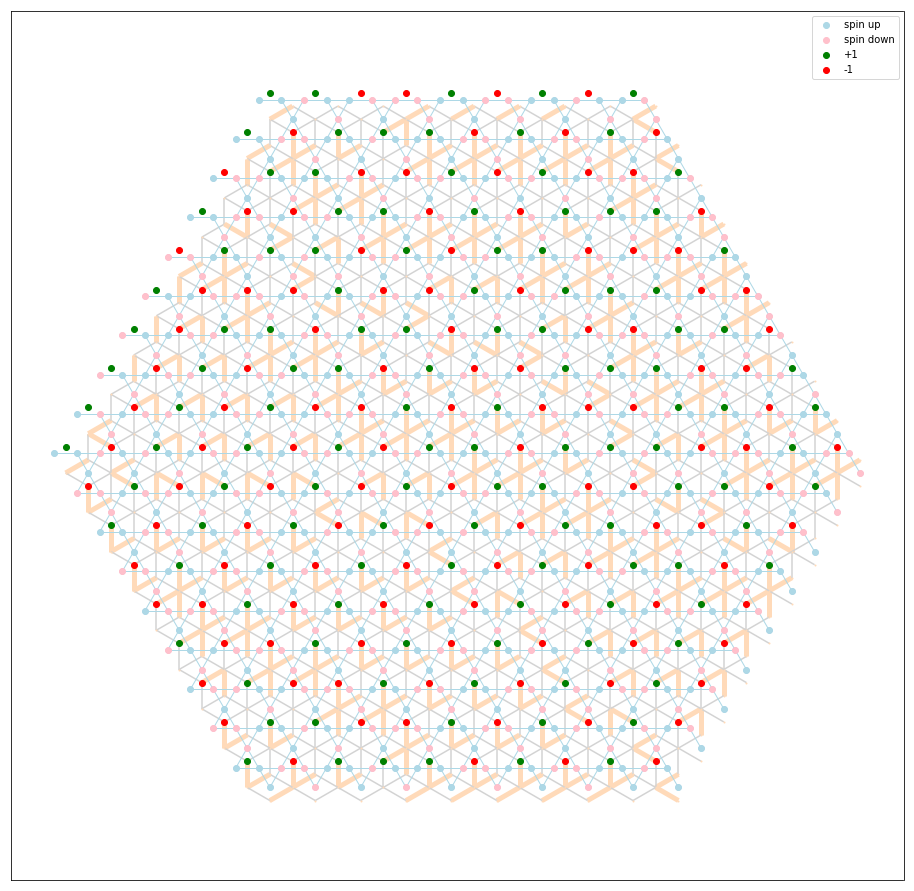

In [18]:
kdraw.plotstate(0, L, d_ijl, ijl_s, sidlist, didlist, s2_d, [state], [spinstate],
                dim_node_color = 'peachpuff', dim_color ='peachpuff', 
                spin_up_color = 'lightblue', spin_down_color = 'pink')
kdraw.plot_honeycomb_chargestate(chargestate, ijl_c,
                                 L,2,c1_color = 'black', c2_color = 'green',
                                 c3_color = 'red', c4_color = 'black', uponly=True)
plt.legend()
plt.savefig(stroutput+"_folder/PlotsResults/GSConfig.png")

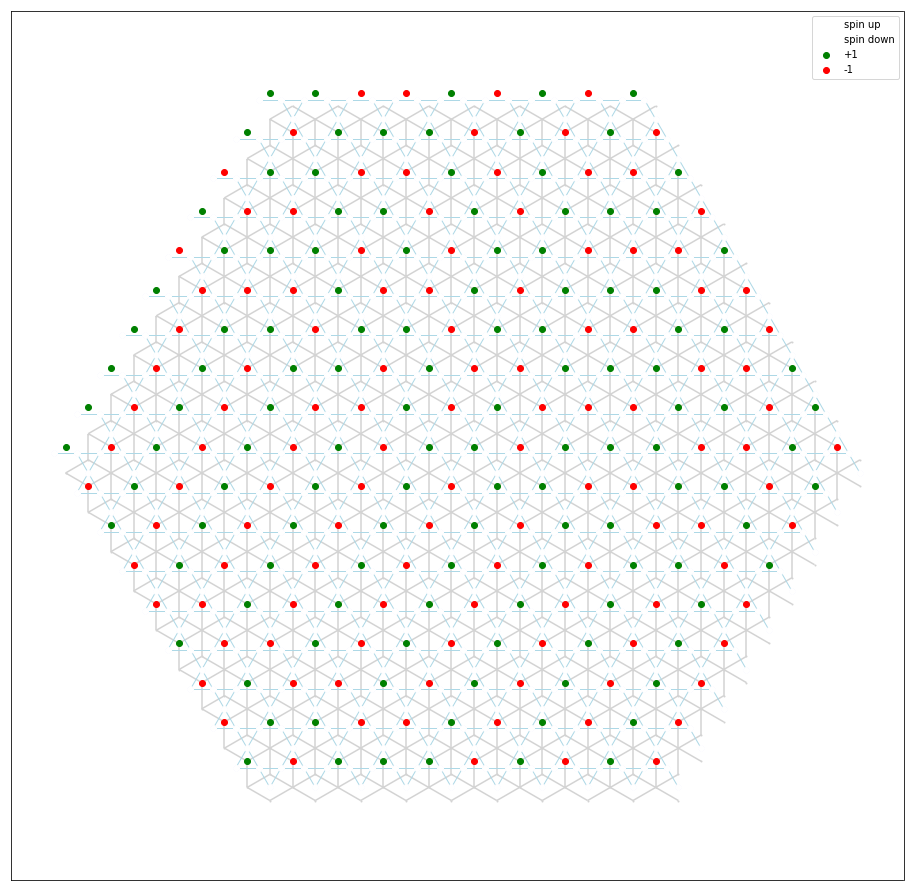

In [19]:
### Try to turn a triangle
kdraw.plotstate(0, L, d_ijl, ijl_s, sidlist, didlist, s2_d, [state], [spinstate],
                dim_node_color = 'lightgrey', dim_color ='lightgrey', dimerlinewidth = 1.5,
                spin_up_color = 'white', spin_down_color = 'white')
kdraw.plot_honeycomb_chargestate(chargestate, ijl_c,
                                 L,2,c1_color = 'black', c2_color = 'green',
                                 c3_color = 'red', c4_color = 'black', uponly=True)

plt.legend()
plt.savefig(stroutput+"_folder/PlotsResults/GSConfigCharges.png")

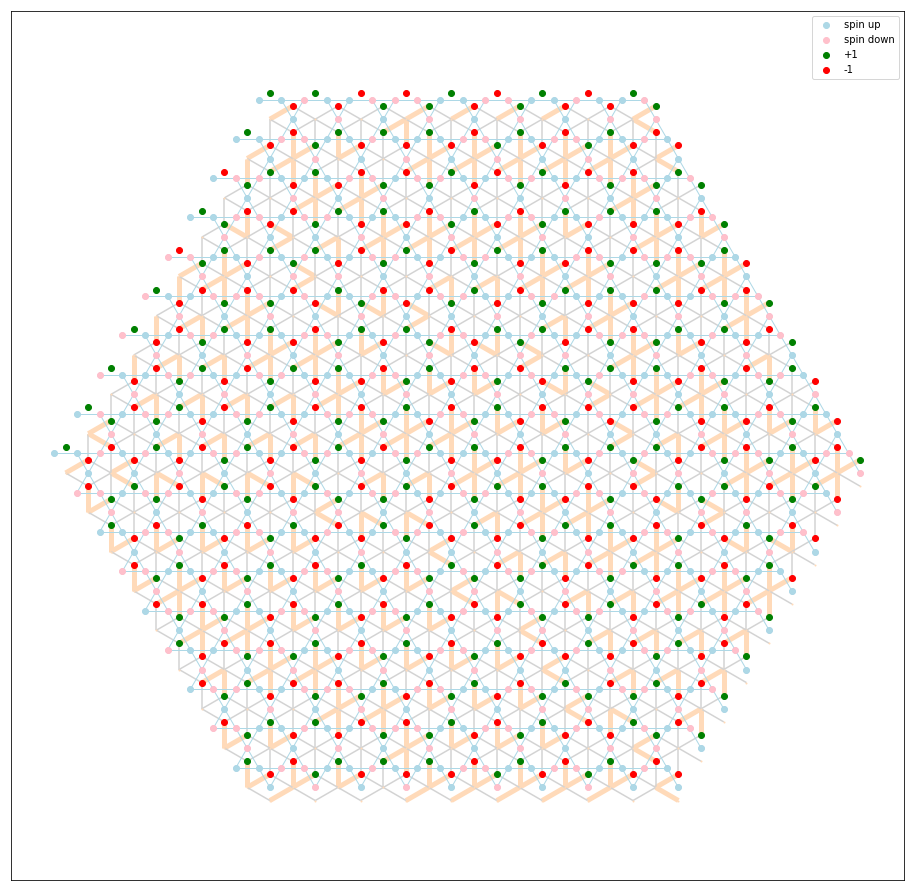

In [20]:
### Try to turn a "triangle"
kdraw.plotstate(0, L, d_ijl, ijl_s, sidlist, didlist, s2_d, [state], [spinstate],
                dim_node_color = 'peachpuff', dim_color ='peachpuff', 
                spin_up_color = 'lightblue', spin_down_color = 'pink')
kdraw.plot_honeycomb_chargestate(chargestate, ijl_c,
                                 L,2,c1_color = 'black', c2_color = 'green',
                                 c3_color = 'red', c4_color = 'black', uponly=False)


#dlist = [ijl_d[(L+2,4,1)],ijl_d[(L+2,4,3)],
#         ijl_d[(L+3,3,4)],ijl_d[(L+3,3,3)],
#         ijl_d[(L+2,3,1)],ijl_d[(L+2,3,2)],
#         ijl_d[(L+3,2,2)],ijl_d[(L+3,2,3)],
#         ijl_d[(L+4,2,3)],ijl_d[(L+4,2,4)],
#         ijl_d[(L+4,3,3)],ijl_d[(L+4,3,5)],
#         ijl_d[(L+4,4,5)],ijl_d[(L+4,4,4)],
#         ijl_d[(L+3,4,2)],ijl_d[(L+3,4,3)],
#         ijl_d[(L+3,5,5)],ijl_d[(L+3,5,4)],
#         ijl_d[(L+2,5,2)],ijl_d[(L+2,5,4)],
#         ijl_d[(L+1,5,2)],ijl_d[(L+1,5,1)]
#        ]
plt.legend()
plt.savefig(stroutput+"_folder/PlotsResults/GSConfig_FullCharges.png")

In [21]:
couplings = {'J1':J1[0], 'J2':J2[0],'J3':J3[0], 'J3st':J3[0]}
hamiltonian = dw.Hamiltonian(couplings, d_ijl, ijl_d, L)
dw.compute_energy(hamiltonian, state, len(s_ijl))

-0.7999999999999975